In [1]:
from jfit import *
from jplot import *
from jFermi2.ImgAnalysis.SingleSiteAnalysis import *
import glob

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 80

In [2]:
########################
### Helper Functions ###
########################
def load_imgs(run_name):
    # Load images
    img1 = np.loadtxt(os.path.join('Data', run_name+'_binned1.txt'))
    img2 = np.loadtxt(os.path.join('Data', run_name+'_binned2.txt'))
    # Find COM and shift the images
    img = img1+img2
    _x0, _y0 = get_com(img)
    _dim_x, _dim_y = img.shape
    img1_s = scipy.ndimage.shift(img1, (-(_x0-_dim_x/2.), -(_y0-_dim_y/2.)), order=0, mode='constant', cval=0)
    img2_s = scipy.ndimage.shift(img2, (-(_x0-_dim_x/2.), -(_y0-_dim_y/2.)), order=0, mode='constant', cval=0)
    return img1_s, img2_s

def show_stats(df):
    def plot_hist(df, ax, variables, xrange, resolution):
        for ii, _var in enumerate(variables):
            x0, x1 = xrange
            nx = int((x1-x0)/resolution)
            *_, = ax.hist(df[_var], bins=np.linspace(x0, x1, nx), rwidth=0.5, alpha=0.75, align='left')
        setlabels(ax, [', '.join(variables), ''])
        
    fig, axs = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
    axs = axs.ravel()
    plot_hist(df, axs[0], ['com_x', 'com_y'], xrange=[20, 40], resolution=1)
    plot_hist(df, axs[1], ['N'], xrange=[0,1200], resolution=10)
    plot_hist(df, axs[2], ['N2'], xrange=[0, 800], resolution=5)
    plot_hist(df, axs[3], ['imbal_corr'], xrange=[-0.6, 0.6], resolution=0.025)
    plot_hist(df, axs[4], ['imbal_s_corr'], xrange=[-0.6, 0.6], resolution=0.025)
    plot_hist(df, axs[5], ['PSF_width_1', 'PSF_width_2'], xrange=[0, 7], resolution=0.25)
    plot_hist(df, axs[6], ['fluor_pk_1', 'fluor_pk_2'], xrange=[400, 1000], resolution=25)
    plot_hist(df, axs[7], ['N1_loss_bri', 'N2_loss_bri'], xrange=[0, 0.3], resolution=0.01)
    plot_hist(df, axs[8], ['N1_hop_bri', 'N2_hop_bri'], xrange=[0, 0.1], resolution=0.005)
    plot_hist(df, axs[9], ['frac_misid_1', 'frac_misid_2'], xrange=[0, 0.3], resolution=0.005)
    plt.show()
    
def load_all_imgs(df):
    imgs = []
    for ii, _id in enumerate(df.index):
        img_up, img_dn = load_imgs(df.loc[_id, 'Run Name'][:-5])
        img_h, img_s, img_d, img_n = get_n_img(img_up+img_dn, [0, 1, 2])
        img_s_up = img_up-img_d
        img_s_dn = img_dn-img_d
        
        # Get isolated unpaired spins as well
        dispToClear = [[0,1]] # Remove all elements of first array that have an element in second array at this displacement, or symmetries 
        img_s_up_isol = clear_ImgOfComparedDisplacements(img_s_up, img_s_dn, dispToClear)
        img_s_dn_isol = clear_ImgOfComparedDisplacements(img_s_dn, img_s_up, dispToClear)
        
        # Polarization
        img_p = img_up-img_dn
        img_p_isol = img_s_up_isol-img_s_dn_isol
        
        # Repulsive spin analog
        img_p_dh = img_d-img_h
        
        imgs.append([img_up, img_dn, img_h, img_s, img_d, img_n, img_s_up, img_s_dn, img_s_up_isol, img_s_dn_isol, img_p, img_p_isol,img_p_dh])
    imgs = dict(zip(['up', 'dn', 'h', 's', 'd', 'n', 's_up', 's_dn', 's_up_isol', 's_dn_isol', 'p', 'p_isol','p_dh'], np.array(imgs).transpose((1, 0, 2, 3))))
    return imgs

def clear_ImgOfComparedDisplacements(imgSeed, imgComp, dispToCheck):
    # Takes imgSeed, and removes all elements that have nonzero values of imgComp at dispToCheck displacements, taking into account symmetries of dispToCheck
    # Ex. dispToCheck = [[0,1], [1,1]]
    permArr = get_symmetry_permutation_unique(dispToCheck) 
    for _p in permArr:
        imgSeed = imgSeed*(1-scipy.ndimage.shift(imgComp, (_p[0],_p[1]), order=0, mode='constant', cval=0))
    return imgSeed

def extract_binned_vals_in_img(_chop_mask, _img): # Takes value from only area in chop mask 
    _, _, binned_val, binned_err = bin_average(_chop_mask, _img, bin_num=2)
    return binned_val[-1], binned_err[-1] 

def extract_binned_vals_in_d_arr(_chop_mask, _img_arr, _d_arr):
    _arr_vals, _arr_errs = [], []
    for _id, _d in enumerate(_d_arr):
        _img_val, _img_err = extract_binned_vals_in_img(_chop_mask, _img_arr[_id])
        _arr_vals.append(_img_val)
        _arr_errs.append(_img_err)
    return np.array(_arr_vals), np.array(_arr_errs)

def gen_chop_mask_radial_arr(rMax,numRadBins, _img):
    # Generates an array of chop mask images which are equal area out to rMax
    rSqArr = np.linspace(0, rMax**2, numRadBins+1, endpoint=True)
    rArr = np.sqrt(rSqArr)
    drArr = np.diff(rArr)
    
    chop_mask_arr = []
    for _ir, dr in enumerate(drArr):
        r_min = rArr[_ir]; r_max = rArr[_ir+1]

        # Build chopping mask
        _dim1, _dim2 = _img.shape
        _dim1c = np.round(_dim1/2).astype(int); _dim2c = np.round(_dim2/2).astype(int)
        chop_mask_outer = np.fromfunction(lambda x, y: np.where(np.sqrt((x-_dim1c)**2+(y-_dim2c)**2)<=r_max, 1, 0), (_dim1, _dim2))
        chop_mask_arr.append(np.fromfunction(lambda x, y: np.where(np.sqrt((x-_dim1c)**2+(y-_dim2c)**2)>=r_min, chop_mask_outer, 0), (_dim1, _dim2)))
    return np.asarray(chop_mask_arr)

# Generate a function to cut out images that are at a specific polarization from the imgs array
def selectImgs(imgs, _dfSelect, selectVarName, selectVals):
    selectLocs = np.intersect1d(np.where(np.array(_dfSelect[selectVarName]).astype(float)>selectVals[0]),np.where(np.array(_dfSelect[selectVarName]).astype(float)<selectVals[1]))
    newValues = np.array([np.array(list(imgs.values())[keyInd][selectLocs]) for keyInd in range(len(list(imgs.keys())))])
    return dict(zip(list(imgs.keys()),newValues))

In [3]:
# 2 Point Correlator functions

def get_symmetry_permutation(d):
    _d = d
    rx = [[-1, 0], [0, 1]]
    rx = [[1, 0], [0, -1]]
    c4 = [[0, -1], [1, 0]]
    for ii in range(2):
        _d = np.dot(rx, _d)
        for jj in range(4):
            yield list(_d)
            _d  = np.dot(c4, _d)
def get_symmetry_permutation_unique(dispArr):
    # ie [[0,1]] generates all rotated combos of [0,1] just once 
    # Ex. dispToCheck = [[0,1], [1,1]]
    permArrNonUniqueFlat = []
    for _d in dispArr:
        for _dSym in list(get_symmetry_permutation(_d)):
            permArrNonUniqueFlat.append(_dSym)
    return np.unique(permArrNonUniqueFlat, axis = 0)

def get_c_ImgArrs(arrs, d_max):
    # Generates an array of 2D images with the connected correlator at displacement d at each point in the image, for each d 
    img_dim = np.array(arrs).shape[2:]    
    _ds, _c_arrs = [], []
    for ii in range(d_max+1):
        for jj in range(ii+1):
            _c, *_,  = get_cij(*arrs, [ii, jj])
            _c_arrs.append(_c)
            _ds.append([ii, jj])
    _rs = [np.sqrt(_d[0]**2+_d[1]**2) for _d in _ds]
    return _ds,_rs,_c_arrs

def build_c_sum_from_c(_d_arr, _r_arr, _c_arr):
    # Generates an array of 2D images 
    # Returns sum of c values at radius less than or equal to d location, taking into account symmetry/degeneracy of rotation
    _deg = [len(np.unique(list(get_symmetry_permutation(_d)), axis=0)) for _d in _d_arr]
    _c_arr_degCorr = np.array([_c_arr[ii]*_deg[ii] for ii in range(len(_deg))])
    _c_sum_arr = np.array([np.sum(_c_arr_degCorr[np.where(_r_arr<=_r)], axis=0) for _r in _r_arr])
    return _c_sum_arr

def build_cmat(d, c):
    # Takes a list of displacements in 2D and correlator values and generates a 2D matrix 
    d_max = int(np.max(d))
    cmat = np.zeros((2*d_max+1, 2*d_max+1))
    for ii, _d in enumerate(d):
        for _d_sym in get_symmetry_permutation(_d):
            _i, _j  = _d_sym
            cmat[_i+d_max, _j+d_max] = c[ii]
    return cmat

In [4]:
# 3 Point Correlator functions 

def get_nijk_ImgArrs(arr0, arr1, arr2, d1to2, d_max):
    # Generates an array of 2D images with the expectation value of nijk
    # d refers to displacement of arr1 from arr0
    # d1to2 refers to displacement of arr2 from arr1
    
    img_dim = np.array(arr0).shape[1:]    
    _ds, _nijk_arrs, _nij_arrs, _nik_arrs, _njk_arrs, _ni_arrs, _nj_arrs, _nk_arrs = [], [], [], [], [], [], [], []
 
    for ii in range(-d_max,d_max+1):
        for jj in range(-d_max,d_max+1):
            _nijk, _nij, _nik, _njk, _ni, _nj, _nk = np.average([get_nijk_SymAvg(arr0[imgInd], arr1[imgInd], arr2[imgInd],  [ii, jj], d1to2) 
                                                                 for imgInd in range(len(arr0))], axis=0)
            _nijk_arrs.append(_nijk)
            _nij_arrs.append(_nij)
            _nik_arrs.append(_nik)
            _njk_arrs.append(_njk)
            _ni_arrs.append(_ni)
            _nj_arrs.append(_nj)
            _nk_arrs.append(_nk)
            _ds.append([ii, jj])
    _rs = [np.sqrt(_d[0]**2+_d[1]**2) for _d in _ds]
    return _ds, _rs, _nijk_arrs, _nij_arrs, _nik_arrs, _njk_arrs, _ni_arrs, _nj_arrs, _nk_arrs

def get_nijk(_img0,_img1,_img2,_d0to1,_d1to2):
    _img1_shift = scipy.ndimage.shift(_img1, (_d0to1[0], _d0to1[1]), order=0, mode='constant', cval=scipy.stats.mode(np.array(_img1).flatten())[0])
    _img2_shift = scipy.ndimage.shift(_img2, (_d0to1[0]+_d1to2[0], _d0to1[1]+_d1to2[1]), order=0, mode='constant', cval=scipy.stats.mode(np.array(_img2).flatten())[0])
    [_nijk, _nij, _nik, _njk, 
     _ni, _nj, _nk] = [np.multiply(_img0,np.multiply(_img1_shift, _img2_shift)), 
                       np.multiply(_img0,_img1_shift), 
                       np.multiply(_img0,_img2_shift), 
                       np.multiply(_img1_shift,_img2_shift), 
                       _img0, _img1_shift,_img2_shift]
    return _nijk, _nij, _nik, _njk, _ni, _nj, _nk

def get_nijk_SymAvg(_img0,_img1,_img2,_d0to1,_d1to2):
    # How to do symmetry averaging on 3 point conditional? We want to keep the relative angles of the various things fixed. 
        # So we want to reflect d1to2 about d0to1, and then we also want to rotate d0to1 around the origin in symmetry permutations while keeping the angle fixed between the two displacements. 
    # Get two permutation lists that are locked in phase to give all the symmetry permutations 
    d0to1List = np.array(list(get_symmetry_permutation(_d0to1)))
    d0to2List = np.array(list(get_symmetry_permutation(np.array(_d0to1)+np.array(_d1to2))))
    d1to2List = d0to2List - d0to1List
    [_nijk_SymAvg, _nij_SymAvg, _nik_SymAvg, _njk_SymAvg, 
     _ni_SymAvg, _nj_SymAvg, _nk_SymAvg]  = np.average([get_nijk(_img0,_img1,_img2, d0to1List[ii], d1to2List[ii]) for ii in range(len(d0to1List))], axis = 0)
    return _nijk_SymAvg, _nij_SymAvg, _nik_SymAvg, _njk_SymAvg, _ni_SymAvg, _nj_SymAvg, _nk_SymAvg

def build_cmat_NonSymAvg(d, c):
    # Takes a list of displacements in 2D and correlator values and generates a 2D matrix 
    d_max = int(np.max(d))
    cmat = np.zeros((2*d_max+1, 2*d_max+1))
    for _i, _di in enumerate(d):
        cmat[_di[0]+d_max, _di[1]+d_max] = c[_i]
    return cmat

# Load Data

Image number before post selection:  130


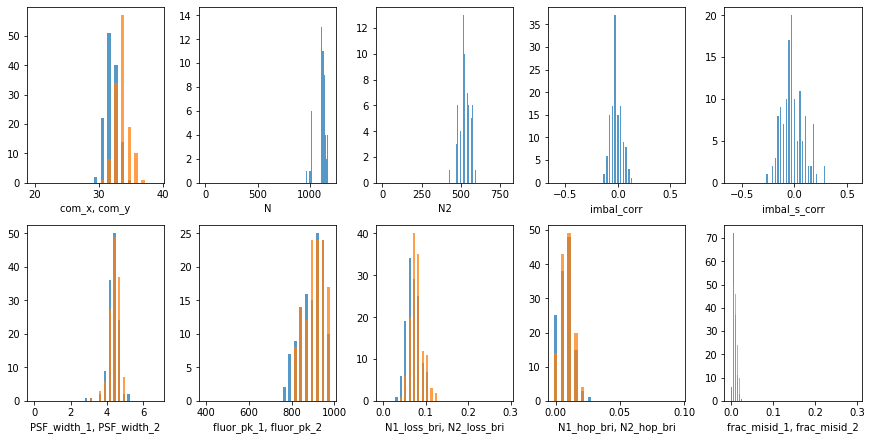

Image number after post selection:  123


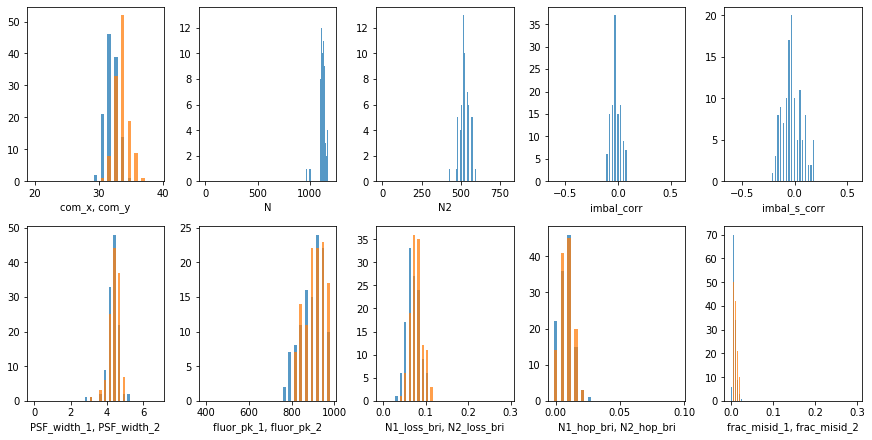

In [5]:
tags =['dset_03_30_2']
nMin = 700; nMax = 1500
n2Min = 0; n2Max = 5000
imbalMin = -0.1; imbalMax = 0.1

df = pd.read_csv(glob.glob('*.csv')[0])
df = df[df['Valid']==1]
# Include only tags that in the tags array 
inTagsArr = (np.array(df['Tag']==tags[0]).astype(bool)|False) # initialize to false 
for tag in tags:
    inTagsArr = inTagsArr | np.array(df['Tag']==tag).astype(bool) 
df = df[inTagsArr]

print("Image number before post selection: ",len(df))
show_stats(df)
_df = df
_df = _df[(_df['N']>=nMin)&(_df['N']<=nMax)]
_df = _df[(_df['N2']>=n2Min)&(_df['N2']<=n2Max)]
_df = _df[(_df['imbal_corr']>=imbalMin)&(_df['imbal_corr']<=imbalMax)]
print("Image number after post selection: ",len(_df))
show_stats(_df)
imgs = load_all_imgs(_df)

In [6]:
# Global parameters for analysis/plots
d_max_glob = 4
rMaxChop_glob = 12
numChopBins_glob = 1

startPlotScaleIndUse = 1
bootStrapNum=8

In [7]:
# for imgInd in range(len(_df)):
#     plt.imshow(imgs['n'][imgInd])
#     print(_df['Run Name'].values[imgInd])
#     plt.show()

## 2 Point Correlations

In [8]:
# 2 point correlation analysis Bootstrapped 
def gen2PointCorrPlotsBootstrap(key, imgsDset,pltRangeg2, bootNum):
    print(key)
    img_n_avg = np.average(imgsDset['n'], axis=0)
    
    chop_mask_arr = gen_chop_mask_radial_arr(rMaxChop_glob,numChopBins_glob, img_n_avg)
    for chop_mask in chop_mask_arr:
        
        n_valArrBoot = []
        n1_valArrBoot = []
        n2_valArrBoot = []
        c_valsArrBoot = []
        c_sum_valsArrBoot = []
        cmatArrBoot = []
        c_summatArrBoot = []

        for _iBoot in range(bootNum):
            # Generate data and bootstrap it to get averages 
            # Generate a random subsample of the images with replacement 
            cutIndsBootstrap = np.random.choice(range(len(imgsDset['n'])),size = len(imgsDset['n']), replace = True)
            # Now generate imgs array from imgsDset 
            dictNames = np.array(list(imgsDset.items())).transpose()[0]
            dictEntries = np.array(list(imgsDset.items())).transpose()[1]
            dictEntriesNew = np.array([dictEntries[iiDict][cutIndsBootstrap] for iiDict in range(len(dictNames))])
            imgs = dict(zip(dictNames, dictEntriesNew))
            
            # Average density images
            img_n_avg = np.average(imgs['n'], axis=0)
            img_n1_avg = np.average(imgs[key[0]], axis=0)
            img_n2_avg = np.average(imgs[key[1]], axis=0)

            d_arr, r_arr, c_arr = get_c_ImgArrs([imgs[key[0]], imgs[key[1]]], d_max=d_max_glob) # Array of 2D Images with connected correlator at that location, for each d
            c_sum_arr = build_c_sum_from_c(d_arr, r_arr, c_arr)

            n_val, n_err = extract_binned_vals_in_img(chop_mask, img_n_avg)
            n1_val, n1_err = extract_binned_vals_in_img(chop_mask, img_n1_avg)
            n2_val, n2_err = extract_binned_vals_in_img(chop_mask, img_n2_avg)
    
            # Extract binned correlator values 
            c_vals, c_errs = extract_binned_vals_in_d_arr(chop_mask, c_arr, d_arr)
            c_sum_vals, c_sum_errs = extract_binned_vals_in_d_arr(chop_mask, c_sum_arr, d_arr)
            # Build correlation matrix 
            cmat = build_cmat(d_arr, c_vals)
            c_summat = build_cmat(d_arr, c_sum_vals)
            
            # Now save these to bootstrap datasets to then plot 
            n_valArrBoot.append(n_val)
            n1_valArrBoot.append(n1_val)
            n2_valArrBoot.append(n2_val)
            c_valsArrBoot.append(c_vals)
            c_sum_valsArrBoot.append(c_sum_vals)
            cmatArrBoot.append(cmat)
            c_summatArrBoot.append(c_summat)

        n_val = np.average(n_valArrBoot ,axis=0)
        n1_val = np.average(n1_valArrBoot ,axis=0)
        n2_val = np.average(n2_valArrBoot ,axis=0)
        c_vals = np.average(c_valsArrBoot ,axis=0)
        c_sum_vals = np.average(c_sum_valsArrBoot ,axis=0)
        cmat = np.average(cmatArrBoot ,axis=0)
        c_summat = np.average(c_summatArrBoot ,axis=0)
        
        n_err = np.std(n_valArrBoot ,axis=0)
        n1_err = np.std(n1_valArrBoot ,axis=0)
        n2_err = np.std(n2_valArrBoot ,axis=0)
        c_errs = np.std(c_valsArrBoot ,axis=0)
        c_sum_errs = np.std(c_sum_valsArrBoot ,axis=0)
        
        # print("<n> = {:.3f} +/- {:.3f}".format(n_val, n_err))
    
        # Plotting result
        startPlotScaleInd = startPlotScaleIndUse
        fig, axs = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
        g2pltScale =  1.3*np.max(np.abs(c_vals[startPlotScaleInd:]/(n1_val*n2_val)))
        pCondpltScaleMid = c_sum_vals[0]/(n1_val)
        pCondpltScaleDelta = 1.3*np.max(np.abs(c_sum_vals[startPlotScaleInd:]/(n1_val)-pCondpltScaleMid))
        # Plot
        axs[0].imshow(cmat/(n1_val*n2_val)+1, cmap='RdBu_r', vmin=1-g2pltScale, vmax=1+g2pltScale)
        jerrbar(axs[1], r_arr, c_vals/(n1_val*n2_val)+1, yerr=c_vals/(n1_val*n2_val)*np.sqrt(np.divide(c_errs,c_vals)**2+(n1_err/n1_val)**2+(n2_err/n2_val)**2))
        jplot(axs[1], [r_arr[0], r_arr[-1]], [1, 1], ls='--', color='0.5')
        setlims(axs[1], None, [1-g2pltScale, 1 + g2pltScale])
        setlabels(axs[1], ["r [sites]", "g2("+ str(key[0])+","+str(key[1])+")"])
        axs[2].imshow(c_summat/n1_val, cmap='RdBu_r', vmin=pCondpltScaleMid-pCondpltScaleDelta, vmax=pCondpltScaleMid+pCondpltScaleDelta)
        jerrbar(axs[3], r_arr, c_sum_vals/n1_val, yerr=(c_sum_vals/n1_val)*np.sqrt(np.divide(c_sum_errs,c_sum_vals)**2+(n1_err/n1_val)**2))
        jplot(axs[3], [r_arr[0], r_arr[-1]], [c_sum_vals[0]/n1_val, c_sum_vals[0]/n1_val], ls='--', color='0.5')
        setlims(axs[3], None, [pCondpltScaleMid-pCondpltScaleDelta,pCondpltScaleMid+pCondpltScaleDelta])
        setlabels(axs[3], ["r [sites]", "Sum(Cond. Prob. of "+str(key[1])+" at x for x<=r)"])

        axs[4].imshow(cmat/(n1_val*n2_val)+1, cmap='RdBu_r', vmin=1-pltRangeg2, vmax=1+pltRangeg2)
        plt.show()

['up', 'dn']


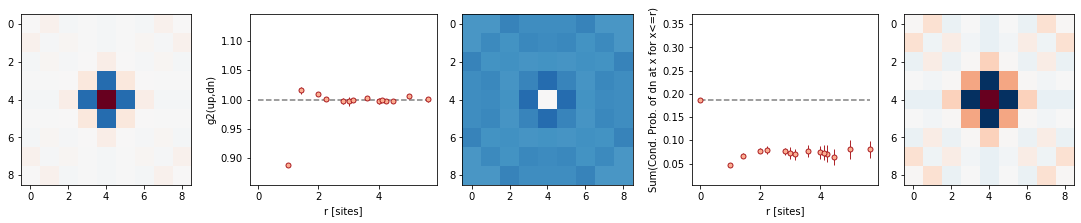

['up', 'up']


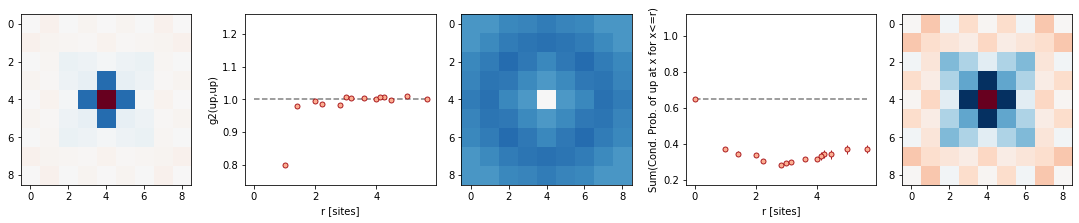

['dn', 'dn']


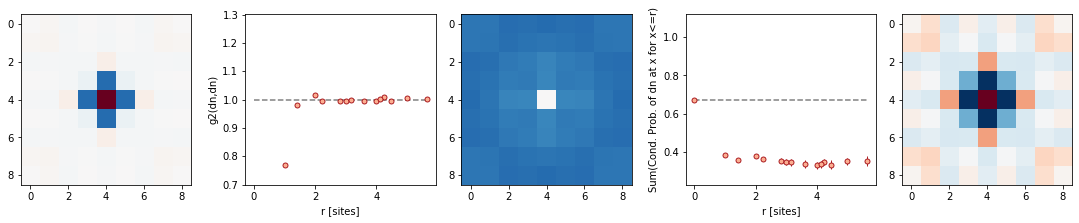

In [9]:
# Generate plots vs imbalance for a given datatset 
pMin=-0.1
pMax=0.1
Np = 1
keys =[ ['up','dn'],['up','up'],['dn', 'dn']]
fixedPlotRange = 0.04

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    for key in keys:
        gen2PointCorrPlotsBootstrap(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange,bootStrapNum)

['s', 's']


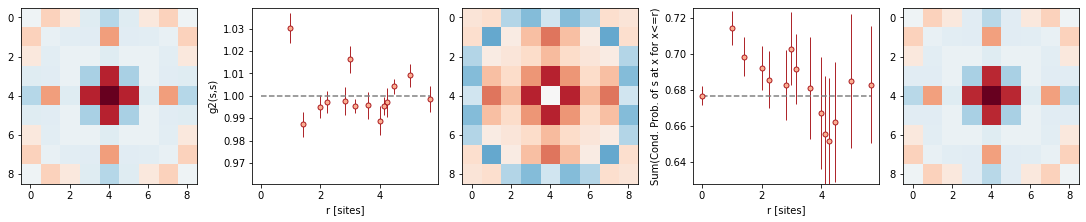

['s_up', 's_dn']


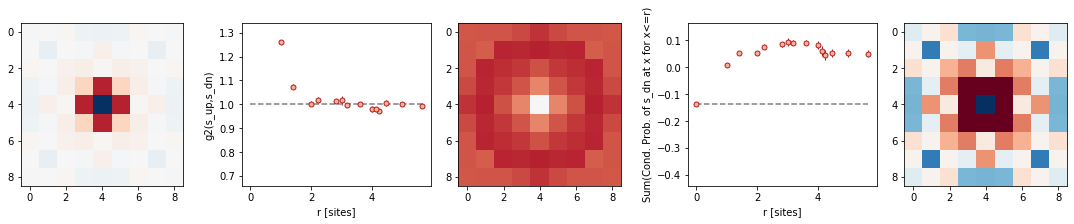

['s_up', 's_up']


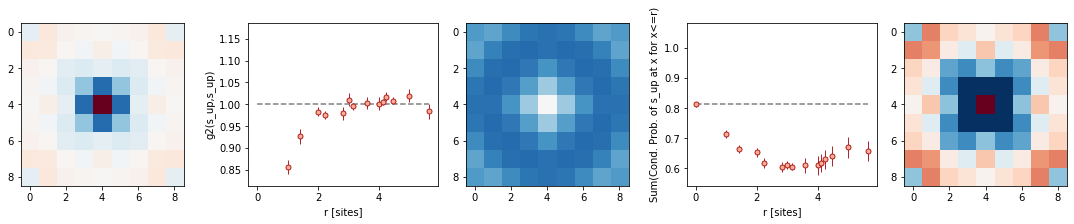

['s_dn', 's_dn']


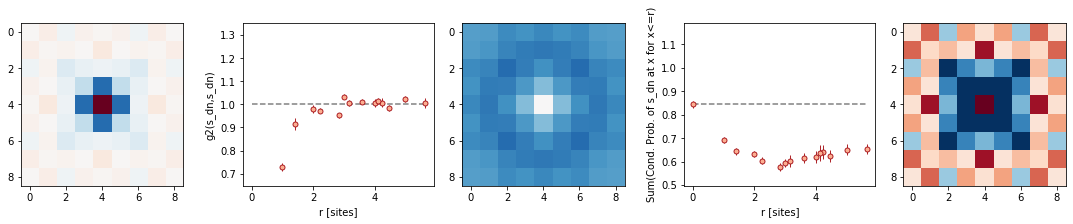

In [10]:
# Generate plots vs imbalance for a given datatset 
pMin=-0.05
pMax=0.1
Np = 1
keys =[['s','s'], ['s_up','s_dn'],['s_up','s_up'],['s_dn', 's_dn']]
fixedPlotRange = 0.04

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    for key in keys:
        gen2PointCorrPlotsBootstrap(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange,bootStrapNum)

['n', 'n']


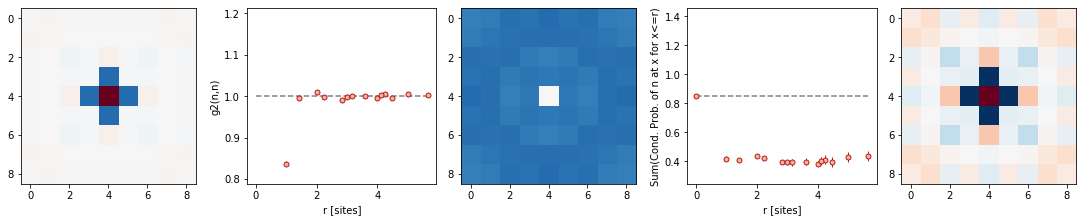

['d', 'd']


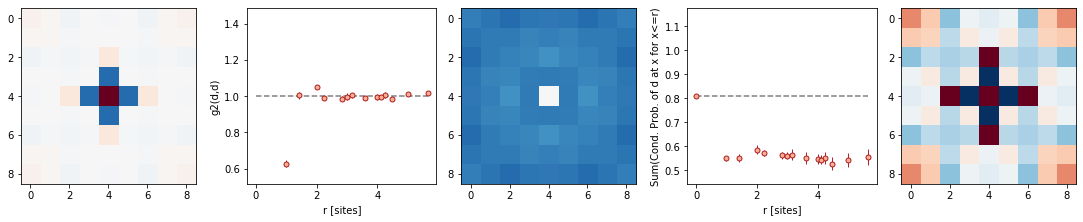

['s', 's']


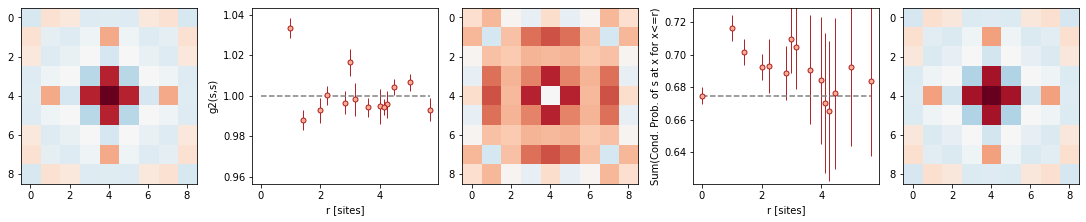

['d', 'h']


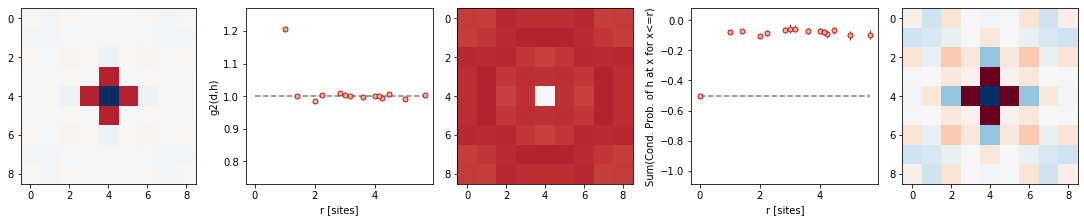

In [11]:
# Generate plots vs imbalance for a given datatset 
pMin=-0.05
pMax=0.1
Np = 1
keys =[ ['n','n'], ['d','d'], ['s','s'], ['d','h']]
fixedPlotRange = 0.04

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    for key in keys:
        gen2PointCorrPlotsBootstrap(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange,bootStrapNum)

['s', 'd']


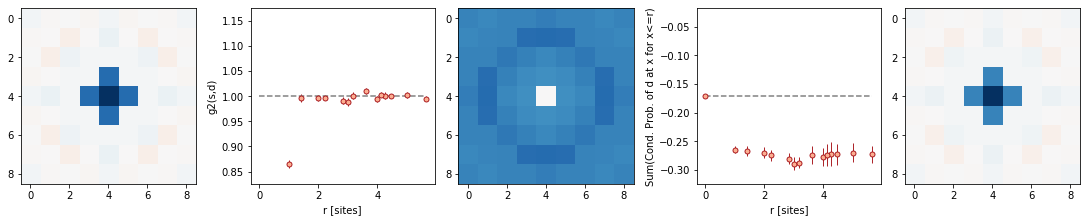

In [12]:
# Generate plots vs imbalance for a given datatset 
pMin=-0.05
pMax=0.1
Np = 1
key = ['s','d']
fixedPlotRange = 0.2

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen2PointCorrPlotsBootstrap(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange,bootStrapNum)

['p', 'p']


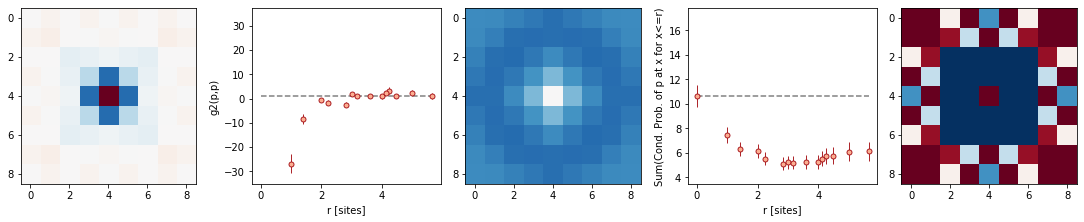

In [13]:
# Generate plots vs imbalance for a given datatset 
pMin=-0.05
pMax=0.1
Np = 1
key = ['p','p']
fixedPlotRange = 0.2

pBinEdgeArr = np.linspace(pMin, pMax, Np+1, endpoint=True)
pArr = [[pBinEdgeArr[ii],pBinEdgeArr[ii+1]] for ii in range(len(pBinEdgeArr)-1)]

for _ip, pRange in enumerate(pArr):    
    gen2PointCorrPlotsBootstrap(key,selectImgs(imgs, _df, 'imbal_corr', pRange), fixedPlotRange,bootStrapNum)